In [251]:
# import libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
pd.plotting.register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

## I. Introduction

https://www.kaggle.com/henriqueyamahata/bank-marketing

### Input variables:
* Bank client data:
   1. age (numeric)
   2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5. default: has credit in default? (categorical: "no","yes","unknown")
   6. housing: has housing loan? (categorical: "no","yes","unknown")
   7. loan: has personal loan? (categorical: "no","yes","unknown")
* Related with the last contact of the current campaign:
   8. contact: contact communication type (categorical: "cellular","telephone") 
   9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
* Other attributes:
   12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
   14. previous: number of contacts performed before this campaign and for this client (numeric)
   15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
* Social and economic context attributes
   16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
   17. cons.price.idx: consumer price index - monthly indicator (numeric)
   18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
   19. euribor3m: euribor 3 month rate - daily indicator (numeric)
   20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
  21. y - has the client subscribed a term deposit? (binary: "yes","no")

### Missing Attribute Values:
There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 


## I. Introduction

## II. DATA UNDERSTANDING

In [252]:
# get data banking marketing from file
file_path = "data/bank-additional-full.csv"
marketing_df = pd.read_csv(file_path,sep = ";")
marketing_df.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
def visualize_numerical(df, column, target = None):

    fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 3));

    sns.histplot(df[column], ax=ax1, kde=True);
    ax1.set_xlabel(column);
    ax1.set_ylabel('Density');
    ax1.set_title(f'{column}  Distribution');
    
    if(target == None):
        sns.boxplot(y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_ylabel(column);
    else:
        sns.boxplot(x=target, y=column, data=df, showmeans=True, ax=ax2);
        ax2.set_xlabel('Target');
        ax2.set_ylabel(column);
    
    plt.show()

def visualize_numerical_lst(df, numerical = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',\
                            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], target = None):
    for column in numerical:
        visualize_numerical(df,column, target)
        print();
        
        
def visualize_categorical(df, column, target = 'y'):
    
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,4))    
        data1 = df.groupby(column).size()
        ax1.pie(x=data1 , autopct="%.2f%%", explode=[0.05]*len(data1), labels=data1.index.tolist(),pctdistance=0.5, radius=1.1)
        ax1.set_title(f'{column}  Distribution')

        data2 = get_col_target(column, target,df)   
        data2.plot(kind='bar',stacked = True, ax=ax2);
        plt.xticks(rotation=45);
        
        plt.show()
    
    
def visualize_categorical_lst(df,categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\
                                          'month', 'day_of_week', 'poutcome'], target = 'y'):
    
    
    for column in categorical:
        visualize_categorical(df, column)
        
def get_col_target(rows, cols,data):
    
    cols_lst = data[cols].unique().tolist()
    rows_lst = data.groupby(rows)[rows].count().sort_values(ascending = False).index.tolist()

    group_df = data.groupby([rows,cols]).size()
    dic = {}
    for item in cols_lst:
        vals = []
        for i in rows_lst:
            try:
                vals.append(group_df.loc[(i, item)])
            except:
                vals.append(0)
            finally:
                continue
        dic[item] = vals

    df = pd.DataFrame(dic,index = rows_lst)
    return(df)


### Những chú ý cho quá trình xử lý

1. Lược bỏ dữ liệu
* Cột 'duration' sẽ không được quan tâm trong quá trình phân tích và xử lý
* Có 12 dòng trùng nhau sẽ cắt bỏ

2. Missing:

* các giá trị unknown của các cột khác: loan, housing, default, marital, job


3. Outlier:
* Age, campain, previous, cons.conf.idx

4. Phân loại lại biến pdays, age

5. Clustering theo 3 chỉ số pdays,previous,poutcome

6. Sự tương quan giữa các biến:
* 3 biến nr.employed, emp.var.rate, euribo3m là 3 biến có tương quan rất mạnh --> có thể lọc bớt để giảm chiều dữ liệu

## III. D A T A PROCESSING

In [253]:
file_path = "data/bank-additional-full.csv"
marketing_df = pd.read_csv(file_path, sep=";")
process_mkt_df = marketing_df.copy()
process_mkt_df.shape

(41188, 21)

In [ ]:
#### Data processing M A I N

### Duplication
Xóa 12 dòng dữ liệu trùng nhau

In [254]:
print('The number of duplicated rows: '+str(len(marketing_df[marketing_df.duplicated()])))
# xóa các dòng trùng nhau
process_mkt_df=process_mkt_df.drop(process_mkt_df[process_mkt_df.duplicated()].index).reset_index(drop=True)
process_mkt_df.shape

The number of duplicated rows: 12


(41176, 21)

### Reality

Loại bỏ cột duration vì nó là 1 thuộc tính ảnh hưởng cao đến biến target

In [255]:
process_mkt_df.pop('duration')
process_mkt_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### MISSING

Giá trị unknown của các cột: default, education, loan, housing, marital, job

In [256]:
def replace_missing_value(df,column,replaced_value,missing_value='unknown'):
    df['process_'+str(column)] = df[column].apply(lambda val: replaced_value if val == missing_value else val)
    return df

1. Biến 'default': khoảng 20% biến này có giá trị 'unknown' - không xác định đc là client có tín dụng xấu hay không - (yes) hay (no).
* Vì đa số biến này cũng khó xác định nên ta sẽ không biến đổi thuộc tính này

2. Biến 'education': 4% là unknown
Thay thế giá trị 'unknown' --> 'university-degree'(bằng giá trị mode của cột dữ liệu)

In [257]:
# edu_unknown = 'unknown'
column = 'education'
replaced_value = process_mkt_df[column].mode().values.tolist()[0]
print('Giá trị education TRƯỚC xử lý: ' + str(process_mkt_df[column].unique().tolist()))
replace_missing_value(process_mkt_df,column,replaced_value)
print('Giá trị education SAU xử lý: ' + str(process_mkt_df['process_'+column].unique().tolist()))

Giá trị education TRƯỚC xử lý: ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
Giá trị education SAU xử lý: ['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'university.degree', 'illiterate']


3. Biến 'loan' và 'housing': 
    * Tỉ lệ missing khá nhỏ: là 2.4% (unknown)
    * Cách xử lý: mục tiêu là càng tiếp thị càng nhiều khách hàng càng tốt, ta đánh vào các giá trị mà tỉ lệ sucessful cao:
        - loan : unknown --> no
        - housing: unknown --> ys

In [258]:
# housing_unknown = 'unknown'
column = 'housing'
#replaced_value = 'no'
replaced_value  = 'yes' #process_mkt_df[column].mode().values.tolist()[0]
print('Giá trị '+ column+ ' TRƯỚC xử lý: ' + str(process_mkt_df[column].unique().tolist()))
replace_missing_value(process_mkt_df,column,replaced_value)
print('Giá trị '+ column+ ' SAU xử lý: ' + str(process_mkt_df['process_'+column].unique().tolist()))

Giá trị housing TRƯỚC xử lý: ['no', 'yes', 'unknown']
Giá trị housing SAU xử lý: ['no', 'yes']


In [259]:
# loan_unknown = 'unknown'
column = 'loan'
#replaced_value = 'no'
replaced_value  = 'no' # process_mkt_df[column].mode().values.tolist()[0]
print('Giá trị '+ column+ ' TRƯỚC xử lý: ' + str(process_mkt_df[column].unique().tolist()))
replace_missing_value(process_mkt_df,column,replaced_value)
print('Giá trị '+ column+ ' SAU xử lý: ' + str(process_mkt_df['process_'+column].unique().tolist()))

Giá trị loan TRƯỚC xử lý: ['no', 'yes', 'unknown']
Giá trị loan SAU xử lý: ['no', 'yes']


4. Biến marital:missing rất thấp 0.1%
unknown --> single

In [260]:
# marital_unknown = 'unknown'
column = 'marital'
#replaced_value = 'single'
replaced_value  = 'single' # process_mkt_df[column].mode().values.tolist()[0]
print('Giá trị '+ column+ ' TRƯỚC xử lý: ' + str(process_mkt_df[column].unique().tolist()))
replace_missing_value(process_mkt_df,column,replaced_value)
print('Giá trị '+ column+ ' SAU xử lý: ' + str(process_mkt_df['process_'+column].unique().tolist()))

Giá trị marital TRƯỚC xử lý: ['married', 'single', 'divorced', 'unknown']
Giá trị marital SAU xử lý: ['married', 'single', 'divorced']


5. Biến job: missing thấp 0.8
unknown --> student

In [261]:
column = 'job'
#replaced_value = 'single'
replaced_value  = 'student' # process_mkt_df[column].mode().values.tolist()[0]
print('Giá trị '+ column+ ' TRƯỚC xử lý: ' + str(process_mkt_df[column].unique().tolist()))
replace_missing_value(process_mkt_df,column,replaced_value)
print('Giá trị '+ column+ ' SAU xử lý: ' + str(process_mkt_df['process_'+column].unique().tolist()))

Giá trị job TRƯỚC xử lý: ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
Giá trị job SAU xử lý: ['housemaid', 'services', 'admin.', 'blue-collar', 'technician', 'retired', 'management', 'unemployed', 'self-employed', 'student', 'entrepreneur']


### Outlier
Age, campain, previous, cons.conf.idx

In [13]:
marketing_df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [262]:
def remove_outlier_by_quantile(df, column, quantile_thresh = 0.95, replaced_value = None):
    if (replaced_value == None):
        replaced_value = df[column].quantile(quantile_thresh)
        
    df['process_'+column] = df[column].apply(lambda val: replaced_value if val > replaced_value else val)
    return df

def remove_outlier_by_value(df, column, value_thresh, replaced_value = None):
    if (replaced_value == None):
        replaced_value = value_thresh
        
    df['process_'+column] = df[column].apply(lambda val: replaced_value if val > value_thresh else val)
    return df

(I). age: thay thế những giá trị > 70 bằng 70
Nhìn biểu đồ thấy sau 70 là outlier

In [263]:
value_thresh = 65
column = 'age' 
process_mkt_df = remove_outlier_by_value(process_mkt_df,column,value_thresh)
process_mkt_df['process_'+column].max()

65

(II). campain: thay thế những giá trị > quantile_95 bằng quantile_95

In [264]:
value_thresh = 6
column = 'campaign' 
process_mkt_df = remove_outlier_by_value(process_mkt_df,column,value_thresh)
process_mkt_df['process_'+column].max()

6

(III). previous: thay thế những giá trị > quantile_95 bằng quantile_95

In [265]:
remove_thresh = float(0.95)
column = 'previous' 
process_mkt_df = remove_outlier_by_quantile(process_mkt_df,column)
process_mkt_df['process_'+column].max()

1.0

In [206]:
# # previous cuối cùng chỉ còn 2 giá trị 0, 1, ta chuyển qua categorical:
# column = 'previous'
# process_mkt_df['process_'+column].value_counts()
# process_mkt_df['process_'+column] = process_mkt_df['process_'+column].astype('category')
# process_mkt_df['process_'+column].head(5)

(IV). cons.conf.idx: thay thế những giá trị > quantile_95 bằng quantile_95

In [266]:
remove_thresh = float(0.95)
column = 'cons.conf.idx' 
process_mkt_df = remove_outlier_by_quantile(process_mkt_df,column)
process_mkt_df['process_'+column].max()

-33.6

### Phân loại lại biến
Age, pdays

(I). Column 'pdays'
* Có đến 96.3% bộ dữ liệu thuộc tính 'pdays' có giá trị '999' - ghi nhận lại đây là những khách hàng chưa được liên hệ bằng call trước đó.
> Vì vậy đối với biến này, ta sẽ biến đổi phân loại thành 3 nhóm: 'not_previously_contacted', 'within_a_week', 'over_a_week'

In [267]:
def transform_pdays(val):
    transform_dict = {999:'not_previously_contacted',7: 'over_a_week',0:'within_a_week'}
    for key in transform_dict.keys():
        if (val >= key):
            return transform_dict[key]

column = 'pdays'
process_mkt_df['process_'+column] = process_mkt_df[column].map(transform_pdays)
process_mkt_df['process_'+column].value_counts()

not_previously_contacted    39661
within_a_week                1117
over_a_week                   398
Name: process_pdays, dtype: int64

### Clustering
pdays,previous,poutcome

### Giảm chiều dữ liệu
* 3 biến nr.employed, emp.var.rate, euribo3m là 3 biến có tương quan rất mạnh --> có thể lọc bớt để giảm chiều dữ liệu
* PCA?

In [20]:
process_mkt_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'process_education', 'process_housing',
       'process_loan', 'process_marital', 'process_job', 'process_age',
       'process_campaign', 'process_previous', 'process_cons.conf.idx',
       'process_pdays'],
      dtype='object')

In [268]:
main_features = ['process_age','process_job','process_marital','process_education','default', 'process_housing',
       'process_loan','contact', 'month', 'day_of_week', 'process_campaign','process_pdays','process_previous', 'poutcome',
                 'emp.var.rate', 'cons.price.idx','process_cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
len(main_features)

20

In [269]:
# 1. 3 biến nr.employed, emp.var.rate, euribo3m là 3 biến có tương quan rất mạnh --> ta giữ lại emp.var.rate, euribo3m
                 
main_features = [item for item in main_features if item not in ['nr.employed']]
len(main_features)

19

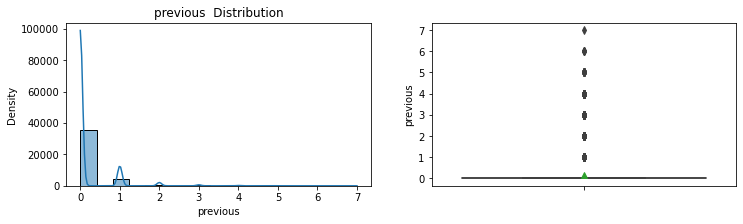

In [23]:
visualize_numerical(marketing_df,column = 'previous')

In [25]:
# visulize dữ liệu
categorical = process_mkt_df[main_features].dtypes[process_mkt_df[main_features].dtypes == 'object'].index.tolist()
numerical = process_mkt_df[main_features].dtypes[process_mkt_df[main_features].dtypes != 'object'].index.tolist()

# categorical = categorical.append('process_previous')
# numerical = numerical.remove('process_previous')

visualize_numerical_lst(model_mkt_df,numerical, target = None)
# Visualization các biến numerical:

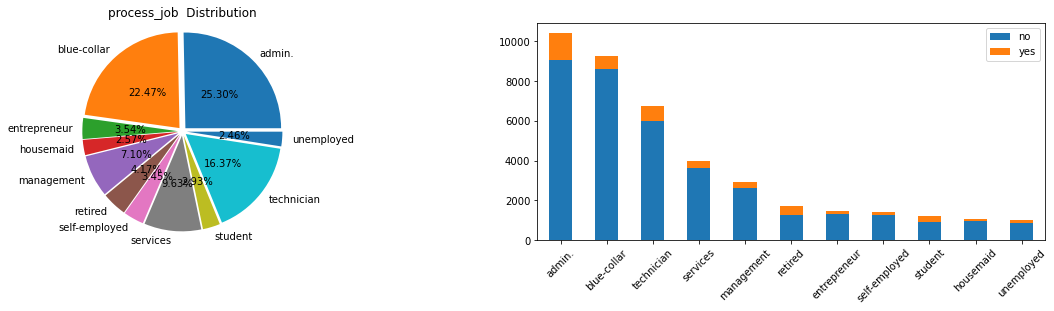

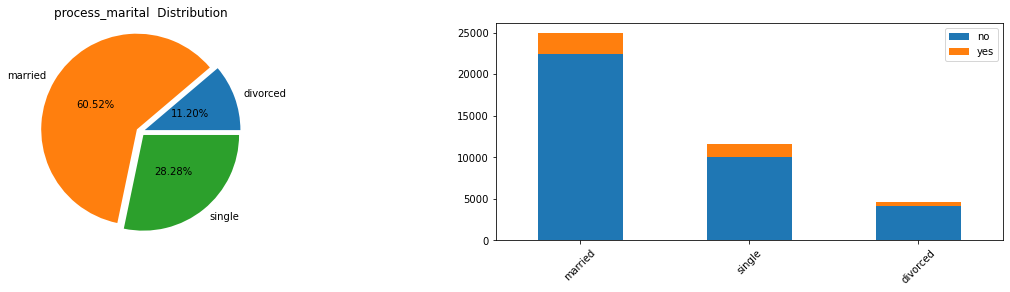

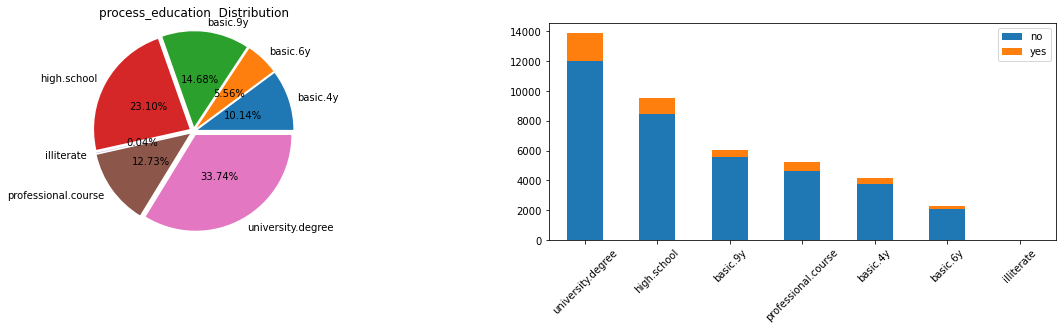

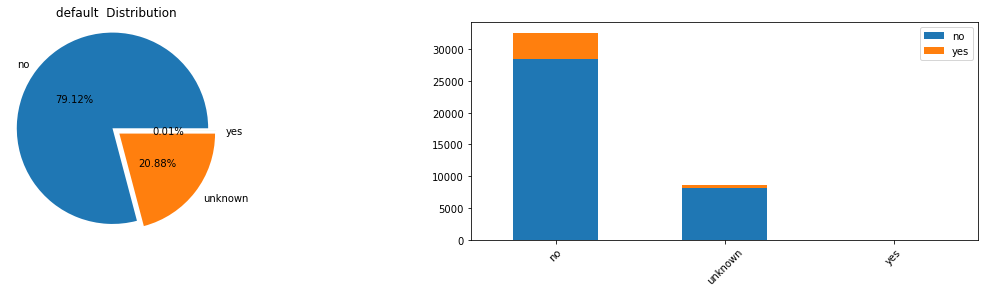

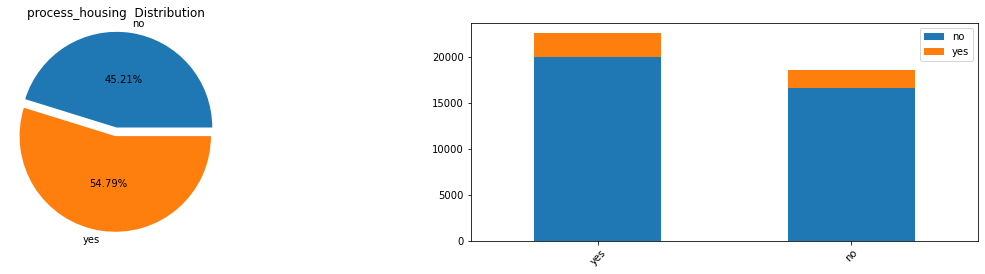

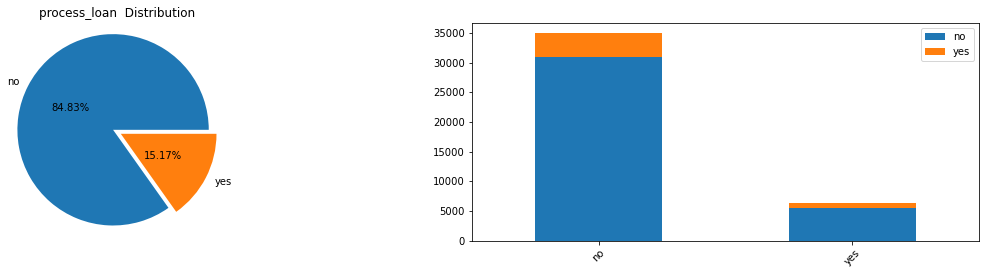

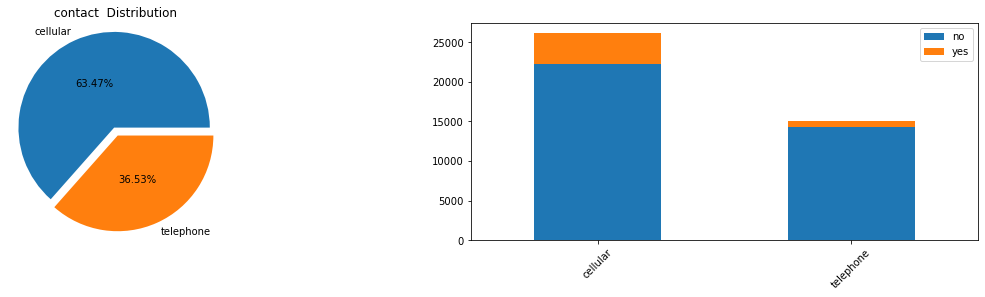

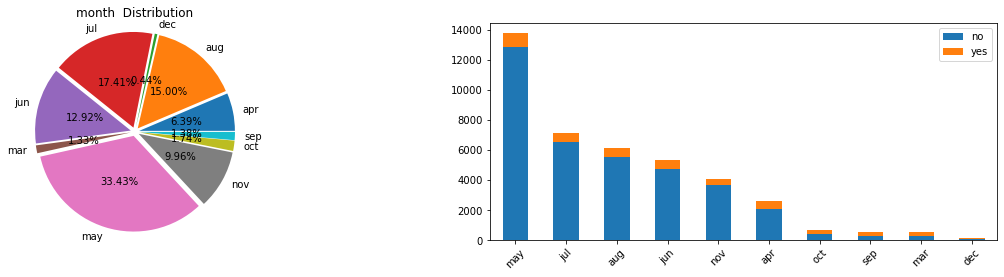

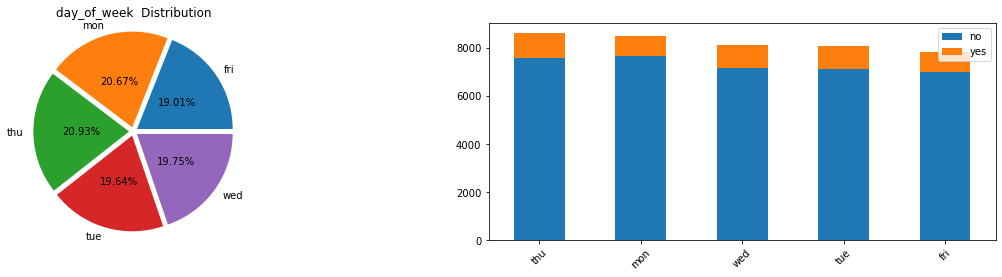

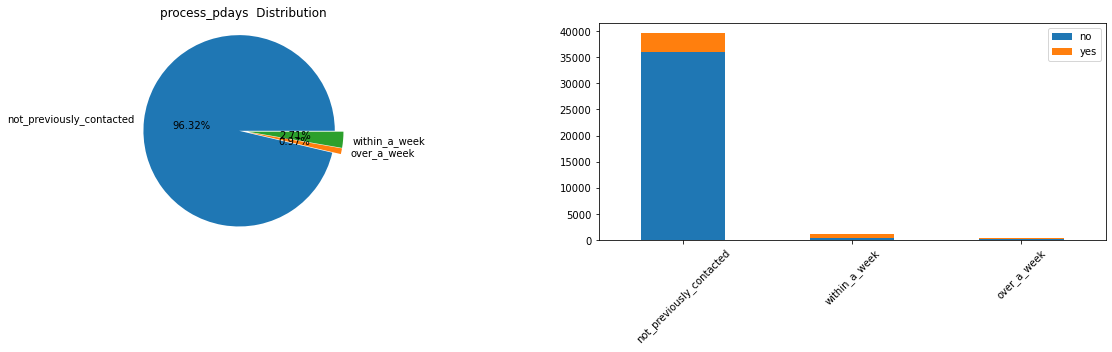

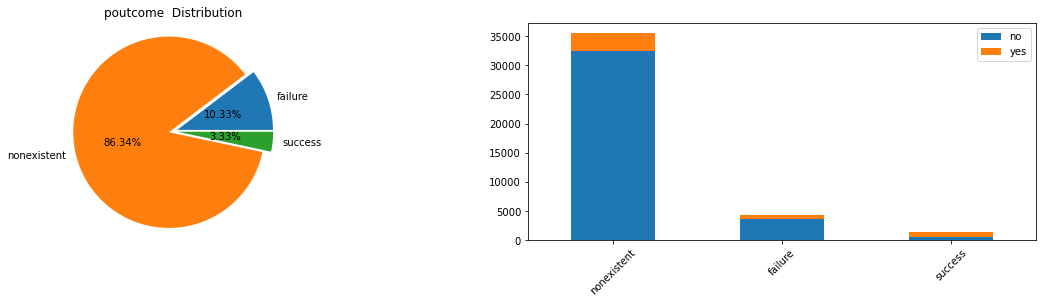

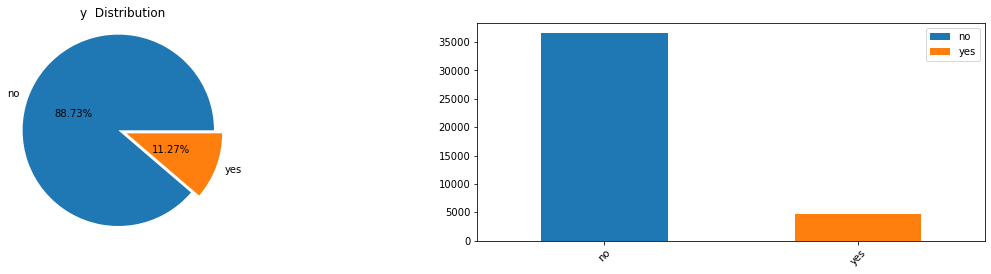

In [192]:
visualize_categorical_lst(model_mkt_df, categorical)

# Visualization các biến numerical:

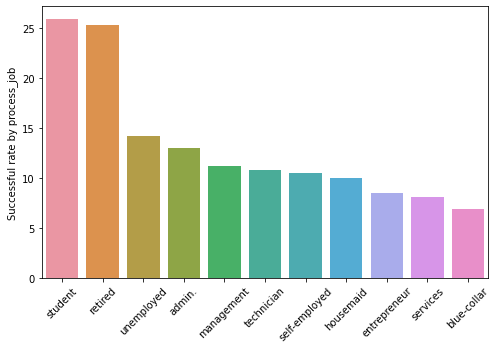

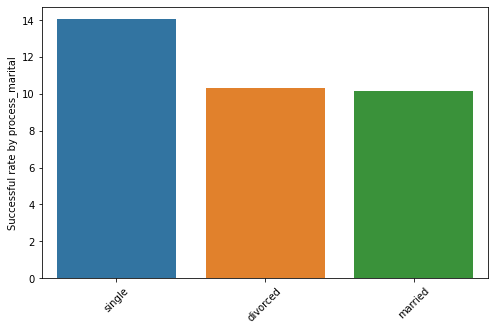

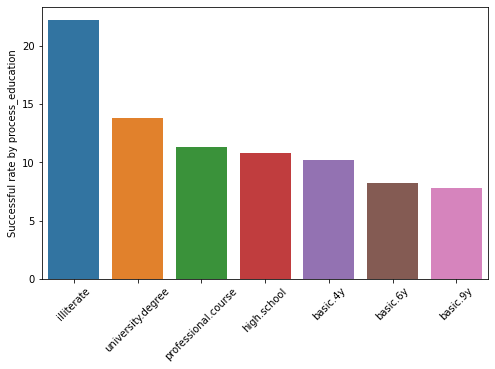

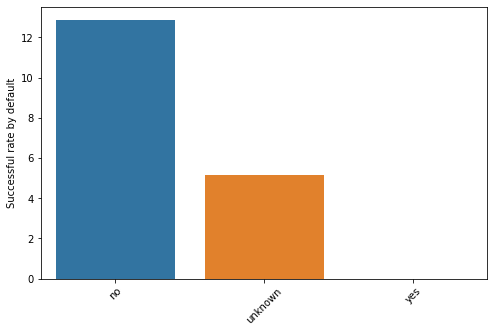

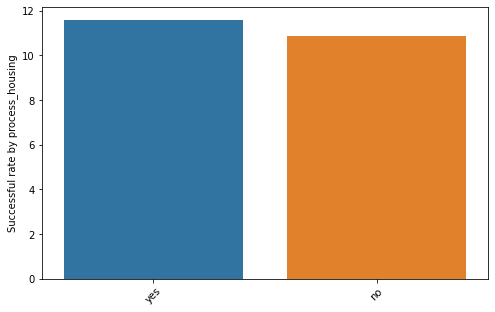

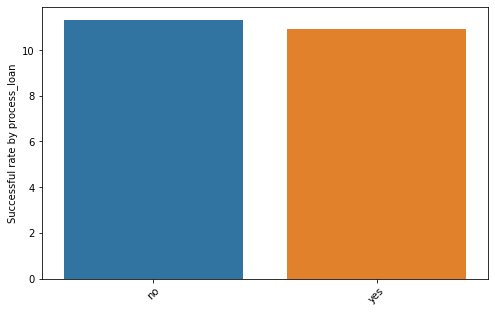

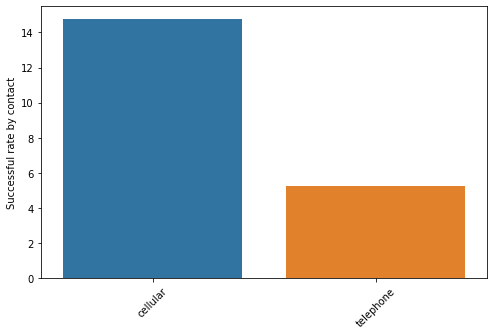

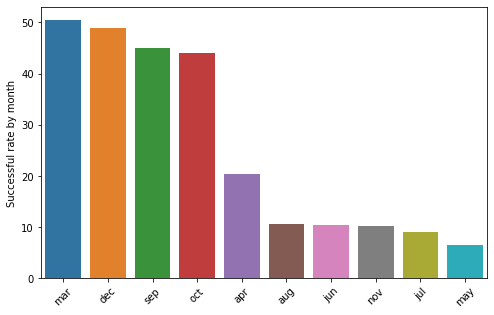

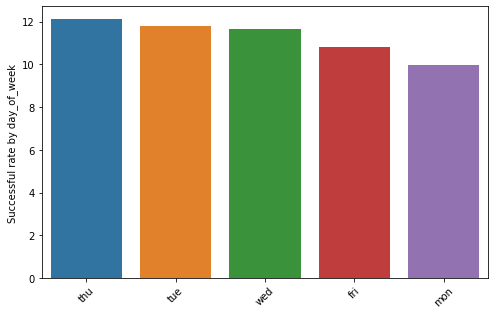

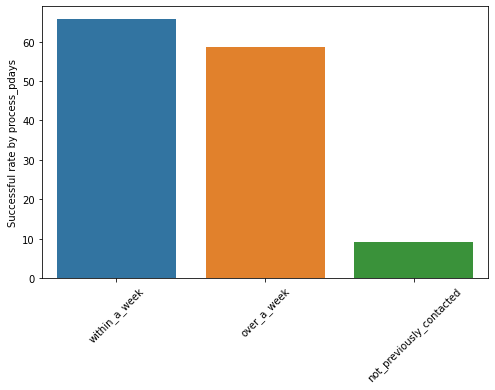

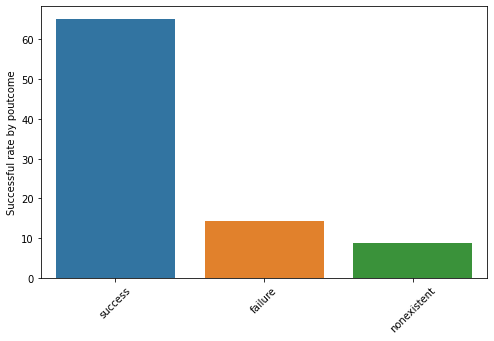

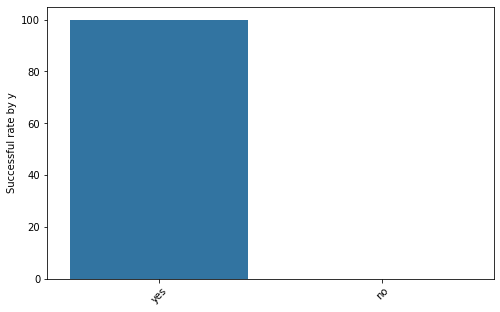

In [167]:
visualize_success_rate(model_mkt_df, categorical)

In [271]:
# import libs
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


from sklearn.linear_model import Lasso, LogisticRegression
# from sklearn.metrics import accuracy_score,make_scorer, mean_squared_error, mean_absolute_error,

from sklearn import datasets, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier



In [272]:
#!pip install xgboost

In [273]:
model_features = main_features
model_mkt_df = process_mkt_df[model_features]

In [274]:
categorical = model_mkt_df.dtypes[model_mkt_df.dtypes == 'object'].index
numerical = model_mkt_df.dtypes[model_mkt_df.dtypes != 'object'].index

### Label encoding

In [275]:
labelencoder = LabelEncoder()
for column in categorical:

    model_mkt_df[column] = labelencoder.fit_transform(model_mkt_df[column])

In [31]:
model_mkt_df.head(2)

,process_age,process_job,process_marital,process_education,default,process_housing,process_loan,contact,month,day_of_week,process_campaign,process_pdays,process_previous,poutcome,emp.var.rate,cons.price.idx,process_cons.conf.idx,euribor3m,y
0,56,3,1,0,0,0,0,1,6,1,1,0,0.0,1,1.1,93.994,-36.4,4.857,0
1,57,7,1,3,1,0,0,1,6,1,1,0,0.0,1,1.1,93.994,-36.4,4.857,0


### Split Train & Test Data: 70% Train - 30% Test

In [276]:
X_train, X_test, y_train, y_test = train_test_split(model_mkt_df.drop('y',axis=1), model_mkt_df['y'],
                                                    test_size=0.3, random_state = 101)
#                                                     stratify= df['y'])

### Normalize

In [277]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## IV. M O D E L I N G

In [250]:
def eval_class(true, predicted):
    acc = metrics.accuracy_score(true, predicted)
    precision = metrics.precision_score(true, predicted)
    recall = metrics.recall_score(true, predicted)
    f1 = metrics.f1_score(true, predicted)
    log_loss = metrics.log_loss(true, predicted)
    auc = metrics.roc_auc_score(true, predicted)
    return acc, precision, recall, f1, log_loss, auc

def create_evaluation_df(model_name, y_train,y_train_pred, y_test, y_test_pred):
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
  
    res_clm = pd.DataFrame(data=[[model_name,*eval_class(y_train,y_train_pred),
                                 *eval_class(y_test, y_test_pred)]],
                          columns=['Model'] + eval_clm_train + eval_clm_test)
    res_clm['diff_Acc_train_test'] = res_clm.apply(lambda x: (x.Accuracy_test - x.Accuracy_train)/x.Accuracy_train, axis=1)
    return(res_clm[dis_clm])

def init_evaluation_df():
    eval_clm_metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Log_loss','AUC']
    eval_clm_train = [m + '_train' for m in eval_clm_metrics]
    eval_clm_test = [m + '_test' for m in eval_clm_metrics]
    dis_clm = ['Model','Accuracy_train'] + eval_clm_test + ['diff_Acc_train_test']
    dis_clm_1 = ['Model','Accuracy_train','Accuracy_test','Precision_test','Recall_test','F1_test']
    
    res_clm = pd.DataFrame( columns=['Model'] + eval_clm_train + eval_clm_test + ['diff_Acc_train_test'])

    return(res_clm[dis_clm])

def run_mode(model):
    model.fit(X_train, y_train)
    # Prediction
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
#     Confusion Matrix
#     metrics.confusion_matrix(y_test_pred, y_test)
#     classification_report
    print('classification_report')
    print(classification_report(y_test,y_pred))
    print()
    print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test,y_test_pred)))
    print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))
    

In [278]:
### Run Models
evalutation_df = init_evaluation_df()

models = [LogisticRegression(max_iter = 300),
          GaussianNB(),
          DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0),
          RandomForestClassifier(n_estimators=1000, max_depth=3),
          GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01),
          XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder = False)
          ]

names = [ 'Logistic Regressor',
          'Naive Bayes',
            'Decision Tree Classifier',
          'Random Forest Classifier',
          'Gradient Boost Classifier',
          'XGBoost Classifier'
        ]

for model,name in zip(models,names):
    model.fit(X_train,y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    model_eval_df = create_evaluation_df(name, y_train,y_train_pred, y_test, y_test_pred)
    evalutation_df = evalutation_df.append(model_eval_df, ignore_index = True)
    


[23:10:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [245]:
evalutation_df 

,Model,Accuracy_train,Accuracy_test,Precision_test,Recall_test,F1_test,Log_loss_test,AUC_test,diff_Acc_train_test
0,Logistic Regressor,0.898846,0.901888,0.692174,0.216658,0.330017,3.388671,0.602281,0.003384
1,Naive Bayes,0.819915,0.823387,0.296816,0.426238,0.349944,6.100102,0.649739,0.004234
2,Decision Tree Classifier,0.995345,0.838686,0.304576,0.347850,0.324778,5.571653,0.624075,-0.157392
3,Random Forest Classifier,0.995345,0.895453,0.558733,0.297768,0.388494,3.610960,0.634124,-0.100360
4,Gradient Boost Classifier,0.922040,0.898185,0.590293,0.284703,0.384135,3.516594,0.629949,-0.025872
5,XGBoost Classifier,0.991014,0.883796,0.467234,0.298857,0.364542,4.013583,0.628040,-0.108190


In [280]:
model = LogisticRegression(max_iter = 300)
model.fit(X_train, y_train)
# Prediction
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# #     Confusion Matrix
# #     metrics.confusion_matrix(y_test_pred, y_test)
# #     classification_report
# print('classification_report')
# print(classification_report(y_test,y_pred))
# print()
# print('Test-set accuracy score: {0:0.4f}'. format(accuracy_score(y_test,y_test_pred)))
# print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_train_pred)))

In [291]:
y_pred_proba = model.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()
fpr, tpr, _  = metrics.roc_curve(y_test,  y_test_pred)
auc = metrics.roc_auc_score(y_test, y_test_pred)
# plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plt.legend(loc=4)
# plt.show()
auc

0.6062078576376566

In [ ]:
#Predicting proba
ytest_pred_prob1 = clf_model.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob2 = logit_model.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob3 = gbm_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob4 = lgbm_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob5 = xgb_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob6 = rf_cmodel.predict_proba(X_test[:,:4])[:,1]
ytest_pred_prob7 = nb_cmodel.predict_proba(X_test[:,:4])[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_class_test, ytest_pred_prob1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_class_test, ytest_pred_prob2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_class_test, ytest_pred_prob3)
fpr4, tpr4, thresholds4 = metrics.roc_curve(y_class_test, ytest_pred_prob4)
fpr5, tpr5, thresholds5 = metrics.roc_curve(y_class_test, ytest_pred_prob5)
fpr6, tpr6, thresholds6 = metrics.roc_curve(y_class_test, ytest_pred_prob6)
fpr7, tpr7, thresholds7 = metrics.roc_curve(y_class_test, ytest_pred_prob7)

# Plot ROC curve
plt.figure(figsize = (15,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot(fpr3, tpr3)
plt.plot(fpr4, tpr4)
plt.plot(fpr5, tpr5)
plt.plot(fpr6, tpr6)
plt.plot(fpr7, tpr7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: High-Value Users Classifiers')
plt.legend(['Baseline','DecisionTreeClassifier','Logit','GBM', 'LightGBM', 'XGBoost', 'RF','Naive Bayes'], loc='lower right')
plt.show()


In [243]:
# # 3. Hệ số mô hình
# logmodel.coef_
# mode.feature_importances

###  ANN Model

In [120]:
#!pip install keras

In [124]:
#!pip install tensorflow

In [125]:
import keras
from keras.models import Sequential
from keras.layers import Dense

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
model = Sequential()
model.add(Dense(input_dim = 2, units = 10, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units = 20, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units = 1, activation='sigmoid', kernel_initializer='uniform'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=500, epochs=10)
model.evaluate(X_test,y_test)
model.evaluate(X_train,y_train)